In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from JINAPyCEE import gamma

import caga; reload(caga);

In [3]:
gt = caga.gamma_tree.load("H1725272_LX11/rsid686.npy")
#gt = caga.gamma_tree.load("H1725272_LX11/rsid23.npy")

In [4]:
kw = gt.kwargs

In [5]:
np.log10(gt.m_DM_0)

12.067528837481948

In [6]:
np.log10(gt.Mpeak)

12.067528837481948

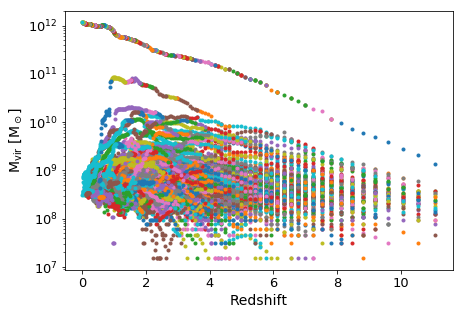

In [7]:
fig = gt.plot_mass_history()

In [8]:
kwargs = caga.generate_kwargs(gt, 1e7)
assert kwargs["pre_calculate_SSPs"]

OMEGA run in progress..
SYGMA run in progress..
   SYGMA run completed - Run time: 0.12s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
Warning -- Not enough gas to sustain the SFH. 2
   OMEGA run completed - Run time: 3.6s
